In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [24]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
device='cuda:0' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

对马鞍山数据集划分训练集和测试集

In [25]:
df_suzhou=pd.read_excel("./data/安庆12.xlsx")
df_suzhou['日期'] = pd.to_datetime(df_suzhou['日期'])
X1_suzhou=df_suzhou.drop(columns=['平均负荷','碳排放强度', '日期','机组'])
y1_suzhou=df_suzhou['碳排放强度']

df_maanshan=pd.read_excel("./data/马鞍山.xlsx")
df_maanshan['日期'] = pd.to_datetime(df_maanshan['日期'])

# out_file=open("D:\FlyFireF\Temp\ITL.txt",'a')
# out_file.write("60-9\n\n")
# df_maanshan = df_maanshan.sample(n=60,random_state=43)
X1 = df_maanshan.drop(columns=['平均负荷','碳排放强度', '日期'])
y1 = df_maanshan['碳排放强度']

# 特征缩放
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()
X1_suzhou_scaled = scaler1.fit_transform(X1_suzhou)
y1_suzhou_scaled = scaler2.fit_transform(y1_suzhou.to_frame())
X1_scaled = scaler3.fit_transform(X1)
y1_scaled = scaler4.fit_transform(y1.to_frame())

y1_suzhou_scaled=pd.Series(y1_suzhou_scaled.flatten())
y1_scaled=pd.Series(y1_scaled.flatten())

# 训练集：宿州数据+80%马鞍山数据，测试集：20%马鞍山数据
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1_scaled, test_size=0.3, random_state=42)
X1_train=np.vstack((X1_suzhou_scaled,X1_train))
y1_train=np.hstack((y1_suzhou_scaled,y1_train))
y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))

排序的特征重要性

In [26]:
def plot_feature_importance(feature_importances):
    sorted_idx = np.argsort(feature_importances)  # 获取按重要性排序的索引
    sorted_feature_names = np.array(X1.columns)[sorted_idx]  # 排序后的特征名
    sorted_feature_importances = feature_importances[sorted_idx]  # 排序后的特征重要性
    sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性
    # 可视化特征重要性和正反相关性
    plt.figure(figsize=(10, 8))
    bars = plt.barh(sorted_feature_names, sorted_feature_importances,height = 0.6,color=np.where(sorted_correlations > 0, '#CA7373', '#4874CB'))
    # 设置y轴标签的字体粗细
    plt.yticks(fontsize=13, fontweight='bold')
    plt.xticks(fontsize=13, fontweight='bold')
    plt.xlabel("特征重要性", fontsize=13, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

预测结果图

In [27]:
def plot_line(pred):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines  # 导入 mlines
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    # 绘制test data预测值和真实值
    plt.figure(figsize=(9, 5))
    plt.plot(pred, label='预测值', linewidth=1,color = "#4874CB")       # 添加预测值的标签
    plt.plot(y1_test_recover, label='实际值', linewidth=1, color='#CA7373')  # 添加真实值的标签
    # 绘制test data的预测值和真实值
    plt.scatter(range(len(pred)), pred, label='预测值',  alpha=0.7,marker= "X",color = "#4874CB")  # 绘制预测值的散点图
    plt.scatter(range(len(y1_test_recover)), y1_test_recover, label='实际值', alpha=0.7, color='#CA7373')  # 绘制真实值的散点图
    # 创建自定义的图例（线+点）
    line1 = mlines.Line2D([], [], color="#4874CB", marker="X", markersize=6, label="预测值")
    line2 = mlines.Line2D([], [], color="#CA7373", marker="o", markersize=6, label="实际值")
    
    # 显示图例
    plt.legend(handles=[line1, line2], fontsize=12.5)
    plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
    plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')
    
    # 显示图表
    plt.tight_layout()  # 调整布局，确保所有元素不重叠
    # plt.savefig("rf1.png",dpi=500,bbox_inches='tight')
    plt.show()

预测值与真实值对比

In [28]:
def plot_compare_line(pred,r2):
    # 计算线性回归拟合系数
    z = np.polyfit(y1_test_recover.T[0], pred, 1)  # 线性拟合
    p = np.poly1d(z)  # 得到拟合的多项式函数
    # 计算拟合值
    y_fit = p(y1_test_recover.T[0])
    # 计算残差
    residuals = pred - y_fit
    # 计算标准误差
    std_err = np.std(residuals)
    # 计算95%置信区间
    confidence_interval = 1.96 * std_err  # 95%置信区间对应的倍数是1.96
    # 使用 pandas DataFrame 排序
    data = pd.DataFrame({'y_test': y1_test_recover.T[0], 'y_pred': pred, 'y_fit': y_fit})
    # 按 'y_test' 升序排序
    data_sorted = data.sort_values(by='y_test')
    # 提取排序后的值
    sorted_y_test = data_sorted['y_test'].values
    sorted_y_pred = data_sorted['y_pred'].values
    sorted_y_fit = data_sorted['y_fit'].values
    # 绘制散点图，x轴为实际值，y轴为预测值
    plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.6, edgecolor='k', label='Data point')
    # 绘制拟合线
    plt.plot(sorted_y_test, sorted_y_fit, color='orange', alpha=0.6, label=f"Fit line\n$R^2$ = {r2:.2f}")
    # 绘制95%置信区间阴影区域
    plt.fill_between(sorted_y_test, sorted_y_fit - confidence_interval, sorted_y_fit + confidence_interval, color='orange', alpha=0.2, label='95% Confidence interval')
    # 添加y=x的参考线，用于比较预测值与实际值的吻合度
    max_val = max(sorted_y_test.max(), sorted_y_pred.max())  # 找到最大值，确保参考线绘制完整
    min_val = min(sorted_y_test.min(), sorted_y_pred.min())  # 找到最小值
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')  # 画出y=x的对角线
    # 图表标题和标签
    plt.title("Comparison of model predictions with real values", fontsize=14)
    plt.xlabel("Real values of CEI / (g/kWh)", fontsize=14)
    plt.ylabel("Predictions of CEI / (g/kWh)", fontsize=14)
    # 显示图例
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

1.SVM

In [29]:
# 创建并训练SVR模型
svr_model = SVR(gamma=0.005,C=4600,epsilon=0.09)
svr_model.fit(X1_train, y1_train)
# 进行预测
svm_y_pred = svr_model.predict(X1_test)

svm_y_pred=scaler4.inverse_transform(pd.DataFrame({'pred':svm_y_pred}))
y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))
# 评估模型
svm_mse = mean_squared_error(y1_test_recover, svm_y_pred)
svm_rmse = np.sqrt(svm_mse)
svm_mae = mean_absolute_error(y1_test_recover, svm_y_pred)
svm_mape = mean_absolute_percentage_error(y1_test_recover, svm_y_pred)
svm_r2 = r2_score(y1_test_recover, svm_y_pred)

print(f"svm_MSE: {svm_mse:.6f}")
print(f"svm_RMSE: {svm_rmse:.6f}")
print(f"svm_MAE: {svm_mae:.6f}")
print(f"svm_MAPE: {svm_mape*100:.6f}")
print(f"svm_R Square: {svm_r2:.6f}")
# out_file.write(f"svm_RMSE,{svm_rmse:.6f}\nsvm_MAE,{svm_mae:.6f}\nsvm_MAPE,{svm_mape*100:.6f}\nsvm_R Square,{svm_r2:.6f}\n\n")

svm_MSE: 14210.586708
svm_RMSE: 119.208165
svm_MAE: 92.596304
svm_MAPE: 18.375501
svm_R Square: 0.567981


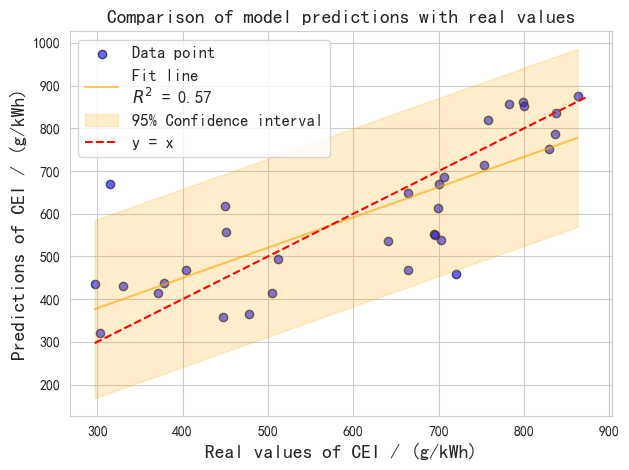

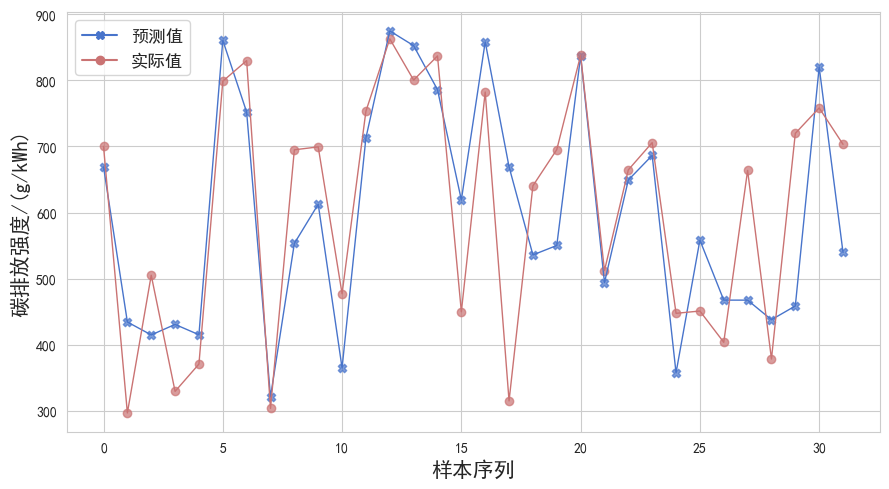

In [30]:
# plot_feature_importance(np.abs(svr_model.coef_).flatten())
plot_compare_line(svm_y_pred.T[0],svm_r2)
plot_line(svm_y_pred)

In [31]:
'''import shap
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
# Use the trained SVR model to create an explainer
explainer = shap.KernelExplainer(svr_model.predict, X1_train)
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X1_test)
# Visualize feature importance using SHAP
shap.summary_plot(shap_values, X1_test, feature_names=X1.columns)'''

"import shap\nplt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei\nplt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题\n# Use the trained SVR model to create an explainer\nexplainer = shap.KernelExplainer(svr_model.predict, X1_train)\n# Calculate SHAP values for the test set\nshap_values = explainer.shap_values(X1_test)\n# Visualize feature importance using SHAP\nshap.summary_plot(shap_values, X1_test, feature_names=X1.columns)"

In [32]:
df_X1_train=pd.DataFrame(X1_train,columns=X1.columns)

In [33]:
def pianYiLai(f1,f2,s1,s2):
    from sklearn.inspection import PartialDependenceDisplay
    import warnings
    warnings.filterwarnings("ignore")
    t2_features3 = [f1, f2,(f1,f2)]
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    # 生成双向部分依赖图
    disp = PartialDependenceDisplay.from_estimator(svr_model, X1, t2_features3)

    disp.axes_.ravel()[0].set_ylabel('偏依赖量/(g/kWh)', fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    disp.axes_.ravel()[2].set_ylabel(s2, fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    disp.axes_.ravel()[0].set_xlabel(s1, fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    disp.axes_.ravel()[1].set_xlabel(s2, fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    disp.axes_.ravel()[2].set_xlabel(s1, fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    plt.subplots_adjust(wspace=0.7)

    # Save the plot to an image file
    #plt.savefig('partial_dependence_plot3.png', dpi=1000, bbox_inches='tight')  # Save as PNG with 500 dpi
    plt.show()

In [34]:
# pianYiLai('负荷率','排烟温度','负荷率平均值(%)','排烟温度/°C')

2.RF

In [35]:
correlation_matrix = df_maanshan.drop(columns=['排汽温度', '日期']).corr()
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_jobs=28,max_depth=26,n_estimators=178,random_state=42)
rf_model.fit(X1_train, y1_train)
rf_y1_pred = rf_model.predict(X1_test)

rf_y1_pred=scaler4.inverse_transform(pd.DataFrame({'pred':rf_y1_pred}))
# y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))

rf_mse = mean_squared_error(y1_test_recover, rf_y1_pred)
rf_rmse = np.sqrt(rf_mse)  # Calculating RMSE
rf_mae = mean_absolute_error(y1_test_recover, rf_y1_pred)
rf_mape = mean_absolute_percentage_error(y1_test_recover, rf_y1_pred)
rf_r2 = r2_score(y1_test_recover, rf_y1_pred)

print(f"rf_MSE: {rf_mse:.6f}")
print(f"rf_RMSE: {rf_rmse:.6f}")
print(f"rf_MAE: {rf_mae:.6f}")
print(f"rf_MAPE: {rf_mape*100:.6f}")
print(f"rf_R Square: {rf_r2:.6f}")
# out_file.write(f"rf_RMSE,{rf_rmse:.6f}\nrf_MAE,{rf_mae:.6f}\nrf_MAPE,{rf_mape*100:.6f}\nrf_R Square,{rf_r2:.6f}\n\n")

rf_MSE: 15001.465942
rf_RMSE: 122.480472
rf_MAE: 97.581573
rf_MAPE: 20.439634
rf_R Square: 0.543937


C:\Users\97112\AppData\Local\Temp\ipykernel_47564\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


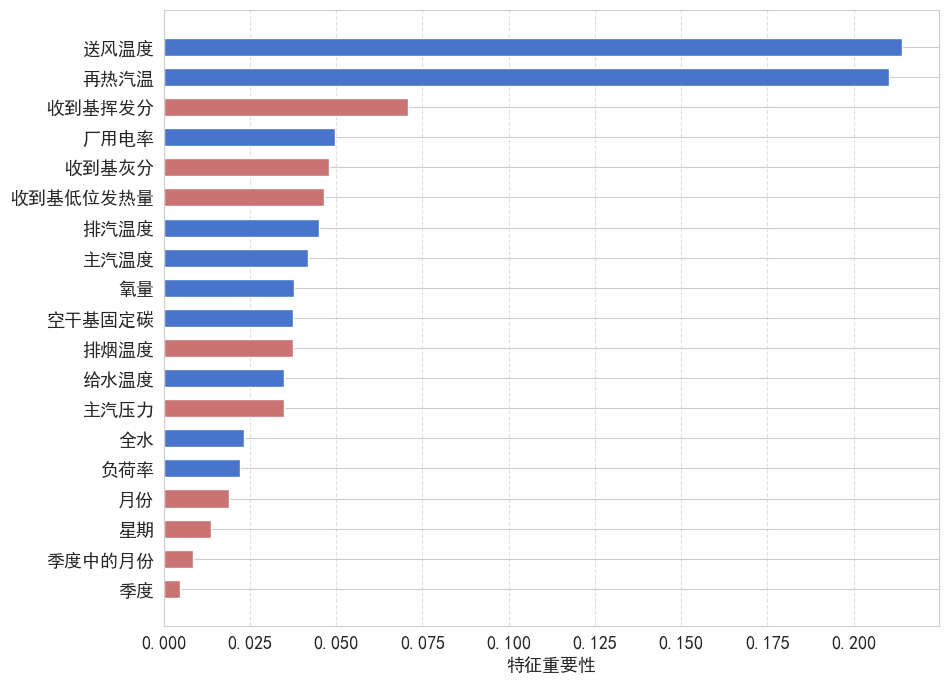

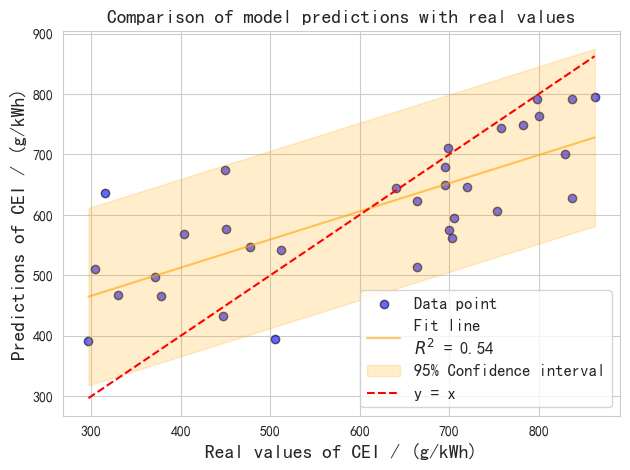

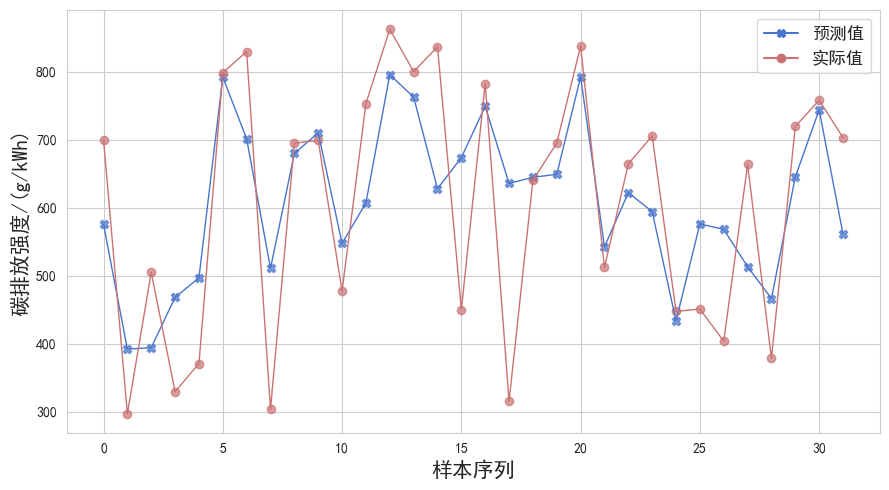

In [36]:
plot_feature_importance(rf_model.feature_importances_)
plot_compare_line(rf_y1_pred.T[0],rf_r2)
plot_line(rf_y1_pred)

3.XGB

In [37]:
from xgboost import XGBRegressor
# 初始化XGBoost回归器
xgb_model = XGBRegressor(
    n_estimators=48,        # 树的数量
    max_depth=7,             # 树的最大深度
    learning_rate=0.1,       # 学习率
    subsample=0.8,           # 每棵树使用的样本比例
    colsample_bytree=0.8,    # 每棵树使用的特征比例
    random_state=42
)
# 训练模型
xgb_model.fit(X1_train, y1_train)
# Predict on the test set
xgb_y1_pred =  xgb_model.predict(X1_test)
xgb_y1_pred=scaler4.inverse_transform(pd.DataFrame({'pred':xgb_y1_pred}))
# y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))
# Evaluate the model
xgb_mse = mean_squared_error(y1_test_recover, xgb_y1_pred)
xgb_rmse = np.sqrt(xgb_mse)  # Calculating RMSE
xgb_mae = mean_absolute_error(y1_test_recover, xgb_y1_pred)
xgb_mape = mean_absolute_percentage_error(y1_test_recover, xgb_y1_pred)
xgb_r2 = r2_score(y1_test_recover, xgb_y1_pred)
print(f"xgb_MSE: {xgb_mse:.6f}")
print(f"xgb_RMSE: {xgb_rmse:.6f}")
print(f"xgb_MAE: {xgb_mae:.6f}")
print(f"xgb_MAPE: {xgb_mape*100:.6f}")
print(f"xgb_R Square: {xgb_r2:.6f}")
# out_file.write(f"xgb_RMSE,{xgb_rmse:.6f}\nxgb_MAE,{xgb_mae:.6f}\nxgb_MAPE,{xgb_mape*100:.6f}\nxgb_R Square,{xgb_r2:.6f}\n\n")

xgb_MSE: 15744.294460
xgb_RMSE: 125.476271
xgb_MAE: 104.557289
xgb_MAPE: 19.747130
xgb_R Square: 0.521354


C:\Users\97112\AppData\Local\Temp\ipykernel_47564\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


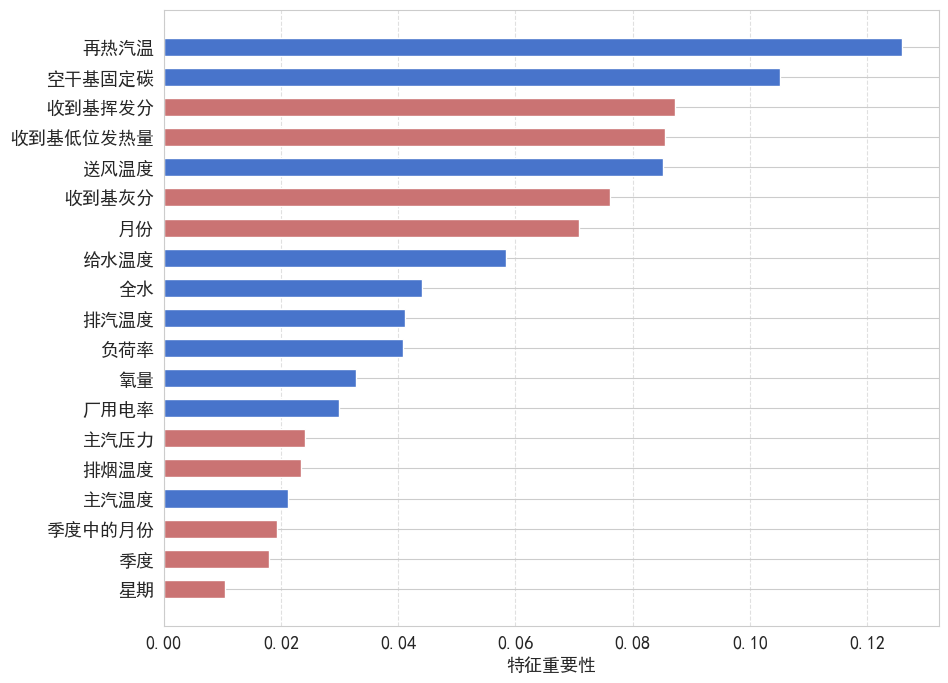

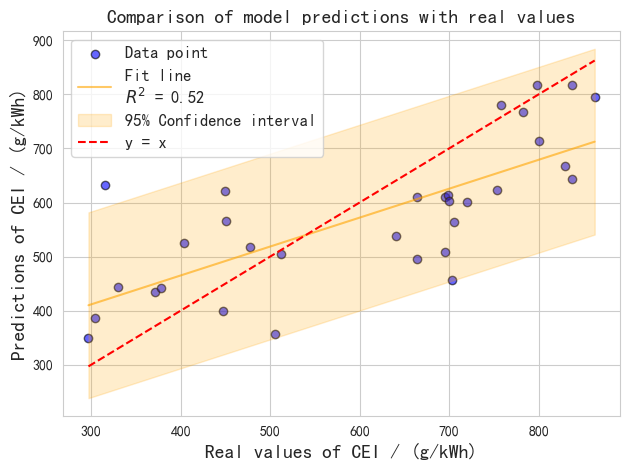

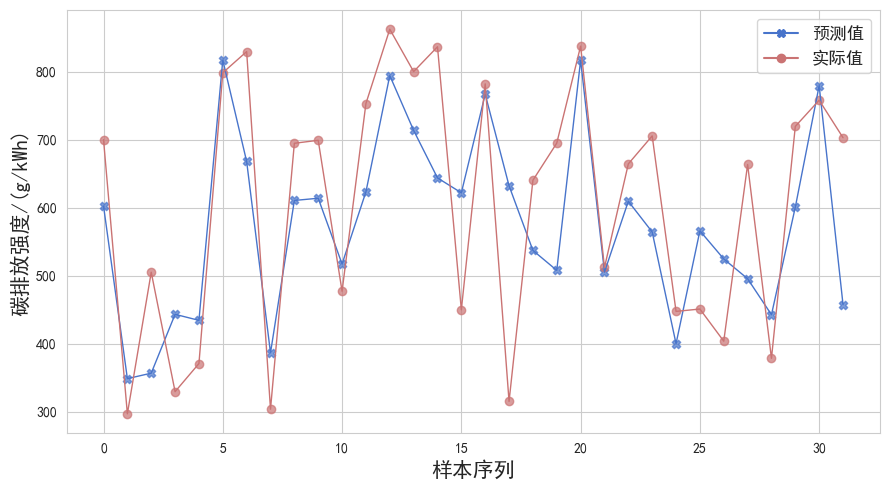

In [38]:
plot_feature_importance(xgb_model.feature_importances_)
plot_compare_line(xgb_y1_pred.T[0],xgb_r2)
plot_line(xgb_y1_pred)

4.LR

In [39]:
from sklearn.linear_model import LinearRegression
# 创建线性回归模型
linear_model = LinearRegression()
# 拟合模型
linear_model.fit(X1_train, y1_train)
# 在测试集上进行预测
linear_y1_pred = linear_model.predict(X1_test)
linear_y1_pred=scaler4.inverse_transform(pd.DataFrame({'pred':linear_y1_pred}))
# y1_test_recover=scaler4.inverse_transform(pd.DataFrame(y1_test))
lr_mse = mean_squared_error(y1_test_recover, linear_y1_pred)
lr_rmse = np.sqrt(xgb_mse)  # Calculating RMSE
lr_mae = mean_absolute_error(y1_test_recover, linear_y1_pred)
lr_mape = mean_absolute_percentage_error(y1_test_recover, linear_y1_pred)
lr_r2 = r2_score(y1_test_recover, linear_y1_pred)
print(f"lr_MSE: {lr_mse:.6f}")
print(f"lr_RMSE: {lr_rmse:.6f}")
print(f"lr_MAE: {lr_mae:.6f}")
print(f"lr_MAPE: {lr_mape*100:.6f}")
print(f"lr_R Square: {lr_r2:.6f}")
print(f"回归系数: {linear_model.coef_}")
print(f"截距: {linear_model.intercept_}")
# out_file.write(f"lr_RMSE,{lr_rmse:.6f}\nlr_MAE,{lr_mae:.6f}\nlr_MAPE,{lr_mape*100:.6f}\nlr_R Square,{lr_r2:.6f}\n\n")

lr_MSE: 21087.070557
lr_RMSE: 125.476271
lr_MAE: 126.990478
lr_MAPE: 26.287733
lr_R Square: 0.358927
回归系数: [ 9.46607533e+11  2.10357230e+11 -1.15696476e+12 -1.19018555e-03
  5.09414673e-02  1.61819458e-01  4.30892944e-01  9.41314697e-02
 -3.44482422e-01 -2.38639832e-01  8.87886047e-01  2.00897217e-01
  2.72735596e-01  1.49475098e-01 -2.26348877e-01  3.17474365e-01
  7.95593262e-02 -1.05818272e-01 -8.31680298e-01]
截距: 0.026769908582669477


C:\Users\97112\AppData\Local\Temp\ipykernel_47564\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


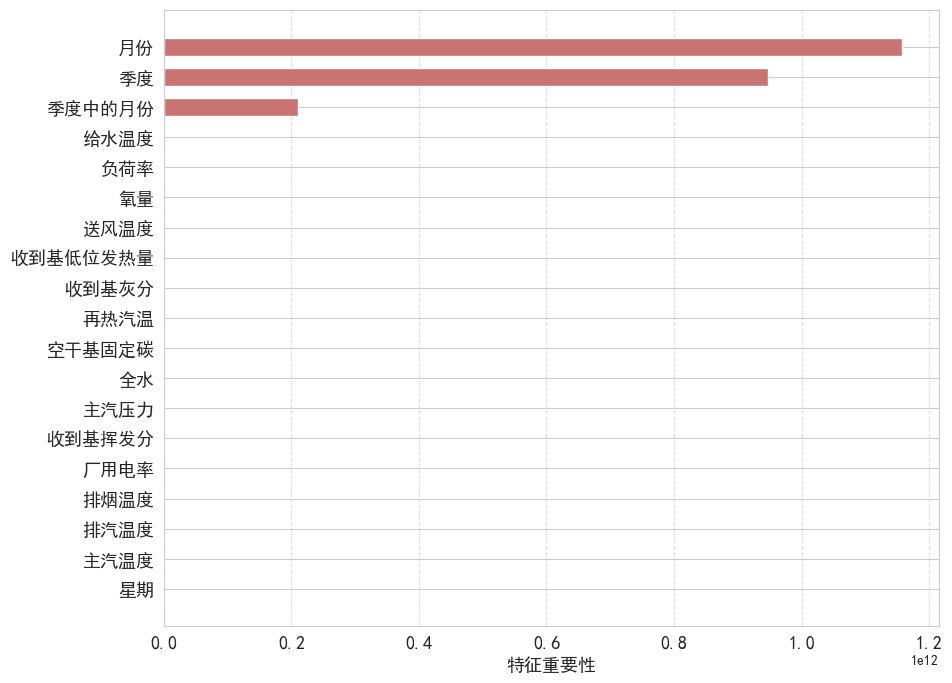

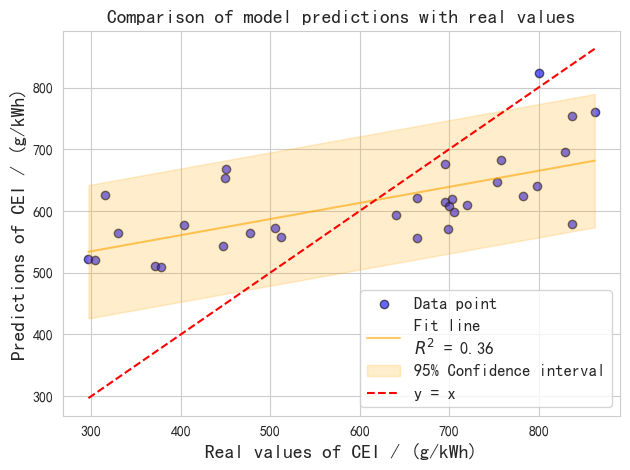

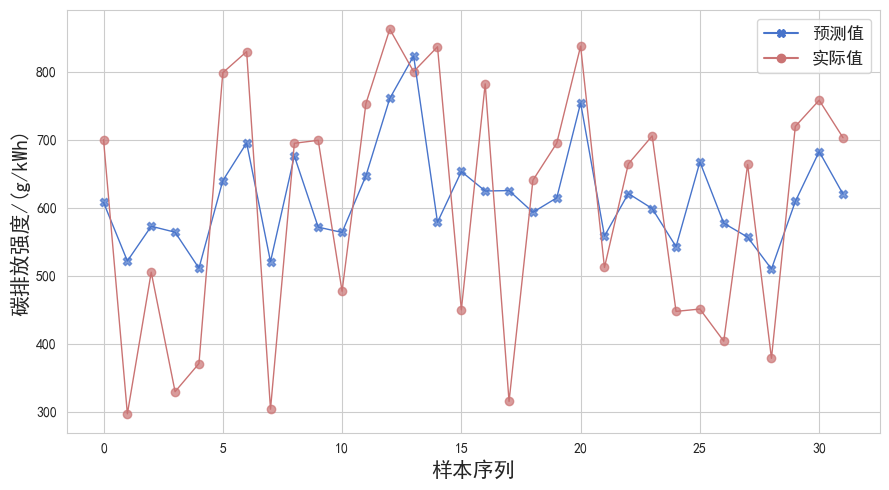

In [40]:
plot_feature_importance(np.abs(linear_model.coef_).flatten())
plot_compare_line(linear_y1_pred.T[0],lr_r2)
plot_line(linear_y1_pred)

5.DNN

In [41]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
device='cuda:0' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

X1_train_tensor=torch.FloatTensor(X1_train).to(device)
y1_train_tensor=torch.FloatTensor(y1_train).view(-1,1).to(device)
X1_test_tensor=torch.FloatTensor(X1_test).to(device)
y1_test_tensor=torch.FloatTensor(y1_test).view(-1,1).to(device)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # 第一个隐藏层
        self.fc2 = nn.Linear(64, 32)          # 第二个隐藏层
        self.fc3 = nn.Linear(32, 1)           # 输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化模型
input_size = X1_train.shape[1]
model = SimpleNN(input_size).to(device)
# 3. 定义损失函数和优化器
criterion = nn.MSELoss().to(device)  # 均方误差损失
optimizer = optim.SGD(model.parameters(), lr=0.12)

# 4. 训练模型
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()  # 设定训练模式
    optimizer.zero_grad()  # 梯度清零
    outputs = model(X1_train_tensor)  # 前向传播
    loss = criterion(outputs, y1_train_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. 评估模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    predictions = model(X1_test_tensor)  # 预测
    test_loss = criterion(predictions, y1_test_tensor)  # 计算测试损失
    print(f'Test Loss: {test_loss.item():.4f}')

predictions=predictions.cpu().numpy().flatten()
predictions=scaler4.inverse_transform(pd.DataFrame({'pred':predictions}))
# Evaluate the model
dnn_mse = mean_squared_error(y1_test_recover, predictions)
dnn_rmse = np.sqrt(dnn_mse)  # Calculating RMSE
dnn_mae = mean_absolute_error(y1_test_recover, predictions)
dnn_mape = mean_absolute_percentage_error(y1_test_recover, predictions)
dnn_r2 = r2_score(y1_test_recover, predictions)
print(f"dnn_MSE: {dnn_mse:.6f}")
print(f"dnn_RMSE: {dnn_rmse:.6f}")
print(f"dnn_MAE: {dnn_mae:.6f}")
print(f"dnn_MAPE: {dnn_mape*100:.6f}")
print(f"dnn_R Square: {dnn_r2:.6f}")
# out_file.write(f"dnn_RMSE,{dnn_rmse:.6f}\ndnn_MAE,{dnn_mae:.6f}\ndnn_MAPE,{dnn_mape*100:.6f}\ndnn_R Square,{dnn_r2:.6f}\n\n")

Epoch [1000/10000], Loss: 0.0156
Epoch [2000/10000], Loss: 0.0131
Epoch [3000/10000], Loss: 0.0117
Epoch [4000/10000], Loss: 0.0103
Epoch [5000/10000], Loss: 0.0110
Epoch [6000/10000], Loss: 0.0084
Epoch [7000/10000], Loss: 0.0082
Epoch [8000/10000], Loss: 0.0083
Epoch [9000/10000], Loss: 0.0069
Epoch [10000/10000], Loss: 0.0075
Test Loss: 0.0291
dnn_MSE: 13326.217808
dnn_RMSE: 115.439239
dnn_MAE: 92.087981
dnn_MAPE: 18.145193
dnn_R Square: 0.594866


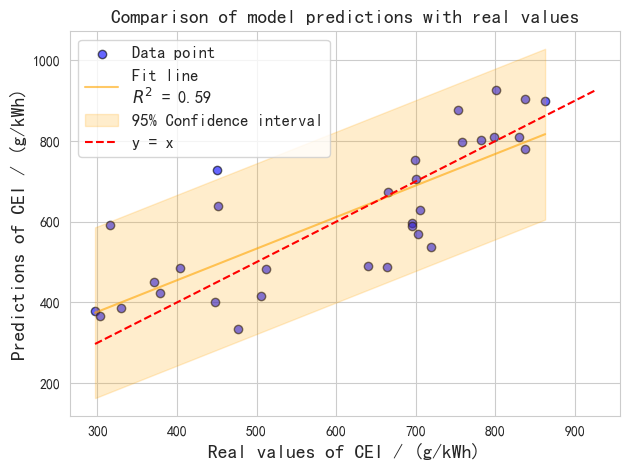

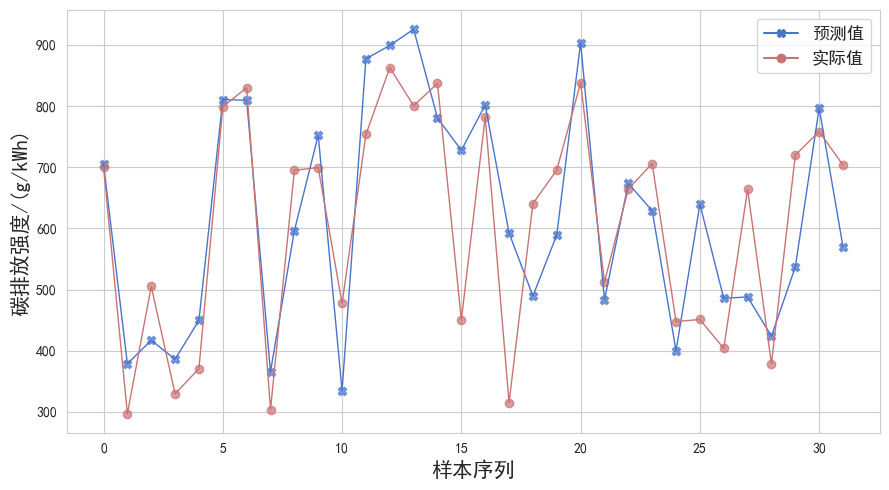

In [42]:
# plot_feature_importance(model.)
plot_compare_line(predictions.T[0],dnn_r2)
plot_line(predictions)

In [43]:
# out_file.flush()
# out_file.close()